# Simple Detection Evaluation 

### Leval 1. Binary Evaluation - Species Present vs Not-Present in image
**Evaluating the performance of object detector on classifying task, i.e - performance on finding the species in images**

1. Overall Level
2. Species level

### Level 2. Species Count 
1. Overall level
2. Speceis level
3. Count level

### Level 3. Incorporate IoU
[Look at this when writing](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

## Level 1: Overall Level
1. Filter out the images that were not user for model training
2. Make predictions on these images
    - wait, we can run the predictions on all the image and then do the step 1
3. Run the queries - predictorExtractor_main.py and prediction_groundtruth_consolidation_main.py
4. Evaluate predictions

In [5]:
# importing the necessary librabies
import csv, glob, sys
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/')
import bootstrapping.prediction_groundtruth_consolidation as pgc

In [14]:
# Defining variabled
round_number = 'round1_ckpt200k'
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

In [16]:
df_pred_gt_consolidated = pgc.combine_pred_groundtruth_consolidated_files(filepath_list)
print(df_pred_gt_consolidated.shape)
print(df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].shape) # Ground Truth Counts
df_pred_gt_consolidated.tail()

(203972, 5)
(143645, 5)


,filename,species,labels,groundtruth_counts,prediction_counts
203967,S10/T11/T11_R2/S10_T11_R2_IMAG1113,eland,27,NaN,1
203968,S10/T11/T11_R2/S10_T11_R2_IMAG1260,dikDik,4,NaN,1
203969,S10/T11/T11_R2/S10_T11_R2_IMAG1323,zebra,5,NaN,1
203970,S10/T11/T11_R2/S10_T11_R2_IMAG1323,warthog,9,NaN,1
203971,S10/T11/T11_R2/S10_T11_R2_IMAG1323,elephant,11,NaN,1


### Level 1: Overall level

# Level 1. Species level

In [17]:
df_pred_gt_consolidated_inter = df_pred_gt_consolidated.to_dict(orient='index')
df_pred_gt_consolidated_dict = {}
for k, v in df_pred_gt_consolidated_inter.items():
    
    if v['filename'] not in df_pred_gt_consolidated_dict.keys():
        df_pred_gt_consolidated_dict[v['filename']] = {}
        if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
            df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 0
            df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 1
        else:
            df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 1
            df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 0

    else:
        if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
            df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 0
            df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 1
        else:
            df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 1
            df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 0
        

In [18]:
# The overall classification accuracy
df_pred_gt_consolidated_leve1_class = pd.DataFrame(df_pred_gt_consolidated_dict).transpose().reset_index()
correct_df = df_pred_gt_consolidated_leve1_class[(df_pred_gt_consolidated_leve1_class.correct_class>=1) \
                                    & (df_pred_gt_consolidated_leve1_class.incorrect_class==0)]
accuracy = sum(correct_df.correct_class)/len(set(df_pred_gt_consolidated_leve1_class.index))
# Precision
precision = sum(df_pred_gt_consolidated_leve1_class.correct_class)/(sum(df_pred_gt_consolidated_leve1_class.correct_class) + sum(df_pred_gt_consolidated_leve1_class.incorrect_class))
print("The overall accuracy in classification: {0}".format(round(accuracy, 3)))
print("The overall precision in classification: {0}".format(round(precision, 3)))

The overall accuracy in classification: 0.664
The overall precision in classification: 0.635


In [7]:
y_true = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["groundtruth_counts"]]
y_pred = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["prediction_counts"]]
print(sum(y_true), sum(y_pred))

tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
print(metric.confusion_matrix(y_true, y_pred))
print(tn, fp, fn, tp)

# For a classification task the recall is:
recall = round(tp/(tp + fn), 3) # Correct
precision = round(tp/(tp + fp), 3)
accuracy = round((tp)/(tp + fn), 3)
f1_score = round(2*recall*precision/(recall + precision), 3)

print("Recall: {0}".format(recall))
print("Precision: {0}".format(precision))
print("F1-Score: {0}".format(f1_score))
print("Accuracy: {0}".format(accuracy))
      

143645 189772
[[     0  60327]
 [ 14200 129445]]
0 60327 14200 129445
Recall: 0.901
Precision: 0.682
F1-Score: 0.776
Accuracy: 0.901


Confusion matrix, without normalization
[[     0  60327]
 [ 14200 129445]]


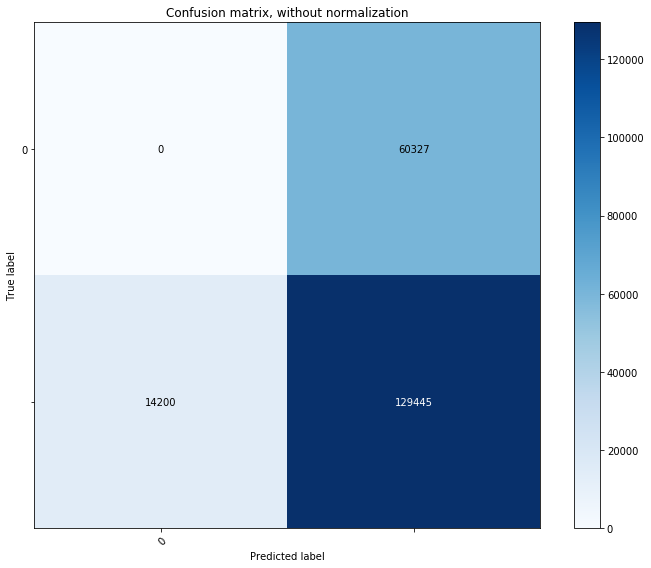

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          round_number,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metric.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('./Dashboard/Species_level_overall_confusion_matrix_{0}.jpg'.format(round_number))
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, round_number = round_number, classes=np.array(['1', '0']),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes=np.array(['false', 'true']), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


In [9]:
species_level_performance_binary = {}
for species in set(df_pred_gt_consolidated['species']):
    species_level_performance_binary[species] = {}
    error = False
    df_temp = df_pred_gt_consolidated[df_pred_gt_consolidated['species']==species]
    y_true = [not(pd.isnull(val)) for val in df_temp["groundtruth_counts"]]
    y_pred = [not(pd.isnull(val)) for val in df_temp["prediction_counts"]]
    try:
        tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
    except Exception:
#         y_true = [2] # to know why this exception run this code
#         y_pred = [2]
#         int(confusion_matrix(y_true, y_pred))
        tn, fp, fn, tp = 0, 0, 0, int(metric.confusion_matrix(y_true, y_pred))
        pass

    species_level_performance_binary[species]['TP'] = tp
    species_level_performance_binary[species]['FP'] = fp
    species_level_performance_binary[species]['TN'] = tn
    species_level_performance_binary[species]['FN'] = fn
    

In [10]:
species_level_performance_binary_df = pd.DataFrame(species_level_performance_binary).transpose().reset_index()
# species_level_performance_binary_df.to_csv('species_level_performance_binary_df.csv')
species_level_performance_binary_df.head()

,index,FN,FP,TN,TP
0,aardvark,15,8,0,54
1,aardwolf,42,8,0,21
2,baboon,126,585,0,495
3,batEaredFox,14,58,0,46
4,buffalo,642,8282,0,3948


# Writing the callable function

In [11]:
%%writefile model_evaluation_metrics.py
# importing the necessary librabies
import csv, glob
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


"""Evaluation at 3 levels:
1. Binary Classification
    a. Overall level - correctly find all the animals in the image
    b. Species level - Correctly find animal in the image
2. Count Level (wip)

3. With IoU (wip)
"""

def get_binary_classifcation_overall_perfomance(pred_groundtruth_consolidate_df):
    """1. a:
    Calculates the overall accuracy of the model. 
    input: DataFrame(output of this code - prediction_groundtruth_consolidation_main) 
            with predictions and groundtruth consolidated.
    output: Accuracy on classification for images. 
            Ex - if the GroundTruth has ['lion', 'cats'] and predictions has ['lion', 'cats'] - Correct,
            else Incorrect
            Precision
    """
    df_pred_gt_consolidated_inter = pred_groundtruth_consolidate_df.to_dict(orient='index')
    df_pred_gt_consolidated_dict = {}
    for k, v in df_pred_gt_consolidated_inter.items():
        if v['filename'] not in df_pred_gt_consolidated_dict.keys():
            df_pred_gt_consolidated_dict[v['filename']] = {}
            if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 0
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 1
            else:
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 1
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 0

        else:
            if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 0
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 1
            else:
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 1
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 0
    
    df_pred_gt_consolidated_leve1_class = pd.DataFrame(df_pred_gt_consolidated_dict).transpose().reset_index()
    # The overall classification accuracy
    correct_df = df_pred_gt_consolidated_leve1_class[(df_pred_gt_consolidated_leve1_class.correct_class>=1) \
                                        & (df_pred_gt_consolidated_leve1_class.incorrect_class==0)]
    accuracy = sum(correct_df.correct_class)/len(set(df_pred_gt_consolidated_leve1_class.index))
    precision = sum(df_pred_gt_consolidated_leve1_class.correct_class)/ \
                            (sum(df_pred_gt_consolidated_leve1_class.correct_class) + \
                             sum(df_pred_gt_consolidated_leve1_class.incorrect_class))
    print("The overall accuracy in classification: {0}".format(round(accuracy, 3)))
    print("The overall precision in classification: {0}".format(round(precision, 3)))
    return accuracy, precision

def get_binary_classifcation_species_level_perfomance(pred_groundtruth_consolidate_df):
    """
    1. b - Species level classification metric. 
    """
    # Overall Species Level
    y_true = [not(pd.isnull(val)) for val in pred_groundtruth_consolidate_df["groundtruth_counts"]]
    y_pred = [not(pd.isnull(val)) for val in pred_groundtruth_consolidate_df["prediction_counts"]]
    tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
    # For a classification task the recall is:
    recall = round(tp/(tp + fn), 3) # Correct
    precision = round(tp/(tp + fp), 3)
    accuracy = round((tp)/(tp + fn), 3)
    f1_score = round(2*recall*precision/(recall + precision), 3)
    
    print("Level 1: Species Level Overall")
    print("Recall: {0}".format(recall))
    print("Precision: {0}".format(precision))
    print("F1-Score: {0}".format(f1_score))
    print("Accuracy: {0}".format(accuracy))
    
    # Per Species Level
    species_level_performance_binary = {}
    for species in set(pred_groundtruth_consolidate_df['species']):
        species_level_performance_binary[species] = {}
        error = False
        df_temp = pred_groundtruth_consolidate_df[pred_groundtruth_consolidate_df['species']==species]
        y_true = [not(pd.isnull(val)) for val in df_temp["groundtruth_counts"]]
        y_pred = [not(pd.isnull(val)) for val in df_temp["prediction_counts"]]
        try:
            tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
        except Exception:
    #         y_true = [2] # to know why this exception run this code
    #         y_pred = [2]
    #         int(confusion_matrix(y_true, y_pred))
            tn, fp, fn, tp = 0, 0, 0, int(metric.confusion_matrix(y_true, y_pred))
            pass

        species_level_performance_binary[species]['TP'] = tp
        species_level_performance_binary[species]['FP'] = fp
        species_level_performance_binary[species]['TN'] = tn
        species_level_performance_binary[species]['FN'] = fn
        
    return species_level_performance_binary

Overwriting model_evaluation_metrics.py


**Evaluating the level performance for (Recall vs Precision) vs Size**

In [13]:
# Gather all the dataset on which to perform the evaluation
import sys, glob
import pandas as pd
# import sklearn.metrics as metric

sys.path.append('./')
import model_evaluation_metrics as mem

filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

df_pred_gt_consolidated = combine_pred_groundtruth_consolidated_files(filepath_list)
## ------------------------------ ##
# 1.a - overall performance
## ------------------------------ ##
accuracy = mem.get_binary_classifcation_overall_perfomance(df_pred_gt_consolidated)

## ------------------------------ ##
# 1.b - Species Level
## ------------------------------ ##
multi_class_confusion_matrix = mem.get_binary_classifcation_species_level_perfomance(df_pred_gt_consolidated)
species_level_performance_binary_df = pd.DataFrame(multi_class_confusion_matrix).transpose().reset_index()
# species_level_performance_binary_df.to_csv('species_level_performance_binary_df.csv', index=False)
species_level_performance_binary_df['Precision'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FP'])
species_level_performance_binary_df['Recall'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])
species_level_performance_binary_df['Accuracy'] = \
     species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])

#### Create a Dataframe with Species to Training Data distribution for the model being evaluated
metric_temp = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/bootstrap_LowerBound50p/Training_data_{}.csv'.format(round_number)

df_temp_gt = pd.read_csv(metric_temp)
df_temp_gt = df_temp_gt[['Species', 'Training_Data_Size', 'Training_Data_freq_normalized']]
# df_temp_gt.head()
#### Creating a DataFrame with Species distribution in the Test Dataset
df_temp_pred = df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].groupby(by=['species'], as_index=False)['filename'].count()
df_temp_pred.columns = ['species', 'Test_Data_Size']
df_temp_pred['Test_Data_freq_normalized'] = df_temp_pred['Test_Data_Size']/sum(df_temp_pred['Test_Data_Size'])

#### Merging the frequency for distributions for trainig and ground truth!
df_distribution_gt_pred = pd.merge(left=df_temp_gt,
                                   right=df_temp_pred,
                                   left_on=df_temp_gt['Species'],
                                   right_on=df_temp_pred['species'],
                                   how='left'
                                  )
df_distribution_gt_pred = df_distribution_gt_pred.drop(columns=['key_0', 'species'])
df_distribution_gt_pred['GT_TD_diff'] = \
                    df_distribution_gt_pred.Training_Data_freq_normalized/df_distribution_gt_pred.Test_Data_freq_normalized
df_distribution_gt_pred.head()

#### Merging the Distribution data for Groundtruth and Predictions into the species level performance metric
species_level_performance_binary_df = pd.merge(left=species_level_performance_binary_df,
                                               right=df_distribution_gt_pred,
                                               left_on=species_level_performance_binary_df['index'],
                                               right_on=df_distribution_gt_pred['Species'],
                                               how='left'
                                              )
species_level_performance_binary_df = species_level_performance_binary_df.drop(columns=['key_0', 'index'])

The overall accuracy in classification: 0.664
The overall precision in classification: 0.635
Level 1: Species Level Overall
Recall: 0.901
Precision: 0.682
F1-Score: 0.776
Accuracy: 0.901


**Plot Performance**

In [14]:
species_level_performance_binary_df.head(n=5)

,FN,FP,TN,TP,Precision,Recall,Accuracy,Species,Training_Data_Size,Training_Data_freq_normalized,Test_Data_Size,Test_Data_freq_normalized,GT_TD_diff
0,15,8,0,54,0.870968,0.782609,0.782609,aardvark,331,0.002395,69.0,0.000480,4.985239
1,42,8,0,21,0.724138,0.333333,0.333333,aardwolf,207,0.001498,63.0,0.000439,3.414577
2,126,585,0,495,0.458333,0.797101,0.797101,baboon,1113,0.008052,621.0,0.004323,1.862561
3,14,58,0,46,0.442308,0.766667,0.766667,batEaredFox,406,0.002937,60.0,0.000418,7.032048
4,642,8282,0,3948,0.322813,0.860131,0.860131,buffalo,5753,0.041621,4590.0,0.031954,1.302533


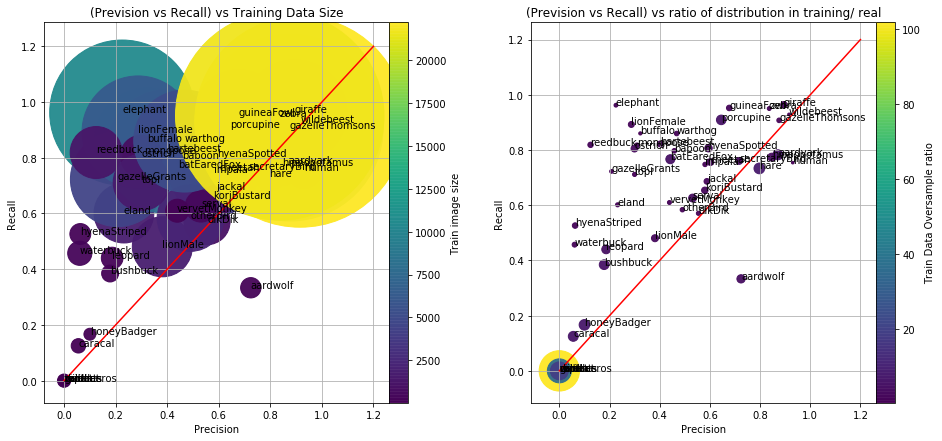

In [12]:
import matplotlib.pyplot as plt

# species_performance_metric = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/metric_temp.csv'

# df_vis = pd.read_csv(species_performance_metric)
df_vis = species_level_performance_binary_df
df_vis = df_vis.fillna(0)
x = df_vis['Precision']
y = df_vis['Recall']

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
#######################################
# Plot for precision vs recall for training data size
im1 = ax1.scatter(x, y, c=df_vis['Training_Data_Size'],\
            s=2*df_vis['Training_Data_Size'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax1.annotate(txt, (x[i], y[i]))
ax1.set_title('(Prevision vs Recall) vs Training Data Size')
ax1.set_xlabel('Precision')
ax1.set_ylabel('Recall')

cbar1 = fig.colorbar(im1, ax=ax1, pad=0)
cbar1.set_label('Train image size')

ax1.grid()
ax1.plot([0, 1.2], [0, 1.2], 'r-')


#######################################
# Plot of Precision vs recall for oversampling ratio
im2 = ax2.scatter(x, y, c=df_vis['GT_TD_diff'],\
            s=16*df_vis['GT_TD_diff'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax2.annotate(txt, (x[i], y[i]))
ax2.set_title('(Prevision vs Recall) vs ratio of distribution in training/ real')
ax2.set_xlabel('Precision')
ax2.set_ylabel('Recall')

# fig.colorbar(im2)
cbar2 = fig.colorbar(im2, ax=ax2, pad=0)
cbar2.set_label('Train Data Oversample ratio')


ax2.grid()
ax2.plot([0, 1.2], [0, 1.2], 'r-')

# Save the figure to the disk
fig.savefig('./Dashboard/Precision_Recall_{0}.jpg'.format(round_number))

In [13]:
species_level_performance_binary_df.to_csv('bootstrap_LowerBound50p/{0}_SS_s10_performance_level_1b.csv'.format(round_number), index=False)

# Level 2: Count
Given the model predicted the correct species, how good it is in the count.
1. **Absolute count per image** - # of animals in ground truth vs # of animals in predictions 
2. **Count per image-species** - # of animals in ground truth vs # of animals in predictions 
3. **Precision and Recall**

In [14]:
# Add parameters
k = 6
print(df_pred_gt_consolidated.shape)

(203972, 5)


In [15]:
# 1.
def get_count_level_performance(df_pred_gt_consolidated, level):
    """Level could be 'overall' or 'species'. The species is a particular species.
    """
    print(level)
    # Absolute Count per image
    df_pred_gt_consolidated_inter = df_pred_gt_consolidated.fillna(0)
    if level!="Overall":
        df_pred_gt_consolidated_inter = df_pred_gt_consolidated_inter[(df_pred_gt_consolidated_inter['species']==level) \
                                                                      & (df_pred_gt_consolidated_inter['groundtruth_counts']!=0)]
        
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    # converting values to integer
    df_pred_gt_consolidated_inter['groundtruth_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['prediction_counts']]


    # Grouping by the animal counts by image
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_inter.groupby(by='filename', as_index=False) \
                ['groundtruth_counts', 'prediction_counts'].sum()
    # ignore all cases with 0 groundtruth or prediction counts
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_count[(df_pred_gt_consolidated_count['prediction_counts']!=0) \
                                                                      | (df_pred_gt_consolidated_count['groundtruth_counts']!=0)]

    df_pred_gt_consolidated_count['df_gt_pred'] = df_pred_gt_consolidated_count.groundtruth_counts - \
                                                        df_pred_gt_consolidated_count.prediction_counts
    df_pred_gt_consolidated_count['df_df_pred_abs'] = [abs(val) for val in df_pred_gt_consolidated_count['df_gt_pred']]

    # calculating correctness in +/- k variance of the groundtruth count
    total_image = len(set(df_pred_gt_consolidated_count.filename))
    
    if total_image == 0:
        return "Divide By Zero"
    accyracy_for_k_round = [round(df_pred_gt_consolidated_count[df_pred_gt_consolidated_count.df_df_pred_abs<=i].shape[0]/total_image, 5) \
                            for i in range(k)]

    for i in range(k):
        print("Accuray with {1} variance: {0}".format(accyracy_for_k_round[i], i))

    # plot bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(k), accyracy_for_k_round)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Deviation')
    ax.set_ylabel('Accuracy')
    ax.set_title('Count Accuracy at different deviation on difference in gt vs prediction: {0}'.format(level))
    ax.grid()
    # Save the figure to the disk
    fig.savefig('./Dashboard/Accuracy_at_variance_bar_{1}_{0}.jpg'.format(round_number, level))
    
    return df_pred_gt_consolidated_count

Overall
Accuray with 0 variance: 0.45656
Accuray with 1 variance: 0.67787
Accuray with 2 variance: 0.76661
Accuray with 3 variance: 0.81808
Accuray with 4 variance: 0.85788
Accuray with 5 variance: 0.88758


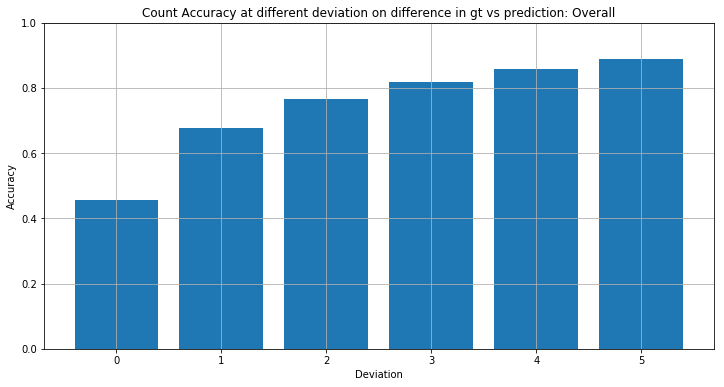

In [16]:
# Plot the overall level performance on count
df_pred_gt_consolidated_count = get_count_level_performance(df_pred_gt_consolidated, "Overall")

# Plot the species level performance on count
# for species in set(df_pred_gt_consolidated.species):
#     get_count_level_performance(df_pred_gt_consolidated, species)

<Figure size 432x288 with 0 Axes>

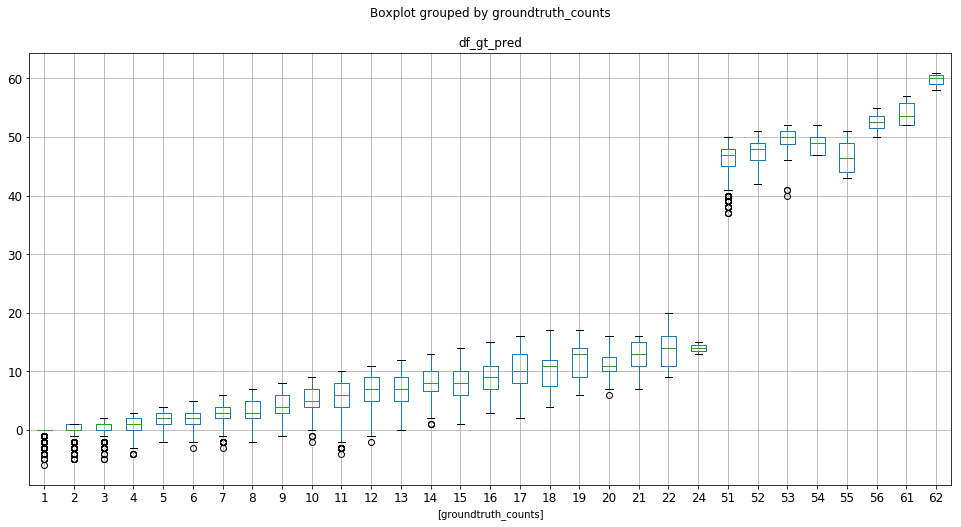

In [17]:
# Box Plot 
plt.figure()
boxplot = df_pred_gt_consolidated_count.boxplot(column=['df_gt_pred'], by=['groundtruth_counts'], fontsize='large', \
                                               figsize=(16, 8))
# Save the figure to the disk
plt.savefig('./Dashboard/Count_level_boxplot_{0}.jpg'.format(round_number))

/home/ubuntu/test_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


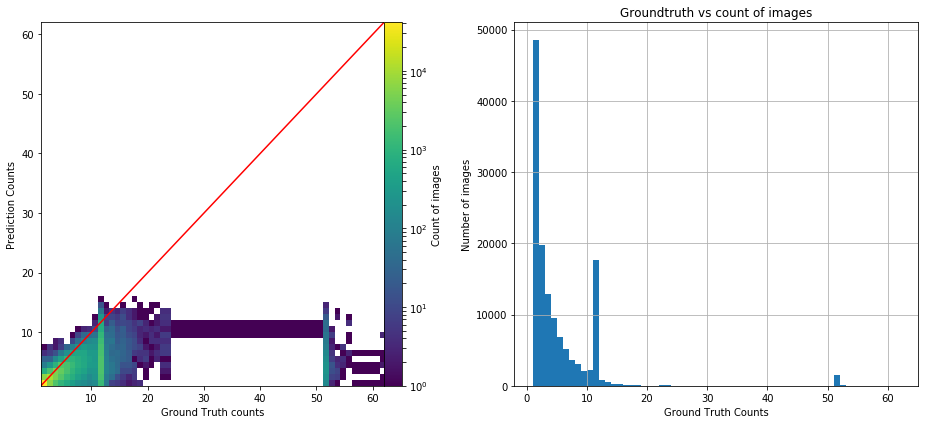

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mco
df_vis1 = df_pred_gt_consolidated_count
df_vis2 = df_pred_gt_consolidated_count
df_vis2.head()


fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), ncols=2)

x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts

limit = 65
edges = np.unique(x)# np.arange(limit+1) + 0.5
bins = edges

out1 = ax1.hist2d(x, y, bins=bins, cmap=plt.viridis(), norm=mco.LogNorm())
img1 = out1[-1]

ax1.set_xlabel('Ground Truth counts')
ax1.set_ylabel('Prediction Counts')

cbar1 = fig.colorbar(img1, ax=ax1, pad=0)
cbar1.set_label('Count of images')

ax1.plot([0, limit+1], [0, limit+1], 'r-')

# ------------------------- #
x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts
edges = np.unique(x)
bins = edges

out2 = ax2.hist(x, bins=bins, normed=False)
img2 = out2[-1]
ax2.set_title('Groundtruth vs count of images')
ax2.set_xlabel('Ground Truth Counts')
ax2.set_ylabel('Number of images')
ax2.grid()

fig.tight_layout()
fig.savefig('./Dashboard/Histogram2d_for_groundtruth_prediction_{0}.jpg'.format(round_number))

###### Bootstrapping Performance